# Apply expected path development to time-series classification
**Data :**
*ItalyPowerDemand* from [UAE](https://www.timeseriesclassification.com/description.php?Dataset=ItalyPowerDemand)


In [1]:
import os
from aeon.datasets import load_from_tsfile
from matplotlib import pyplot as plt
# import numpy as np

In [2]:
data_dir = os.path.join(os.getcwd(), "..", "data", "ItalyPowerDemand")
train_file = "ItalyPowerDemand_TRAIN.ts"
test_file = "ItalyPowerDemand_TEST.ts"

In [3]:
tsx_train, y_train = load_from_tsfile(os.path.join(data_dir, train_file))
tsx_test, y_test = load_from_tsfile(os.path.join(data_dir, test_file))
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Show time series 

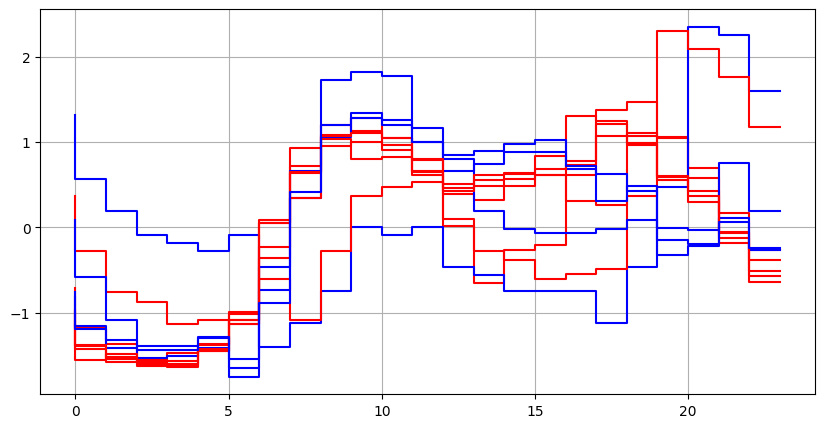

In [4]:
cm = {1: "red", 2: "blue"}
_, ax = plt.subplots(figsize=(10, 5))
x = range(24)
for i in range(10):
    ax.step(x, tsx_train[i, 0, :], c=cm[y_train[i]])
ax.grid()

In [5]:
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))
from development.nn import development_layer
from development.so import so
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
from torch import optim
from sklearn.metrics import confusion_matrix

In [7]:
# time augmentation
tsx_train = np.concatenate(
    [tsx_train, np.repeat(np.array([np.array([list(range(24))])]), len(tsx_train), axis=0)], axis=1
)
tsx_test = np.concatenate(
    [tsx_test, np.repeat(np.array([np.array([list(range(24))])]), len(tsx_test), axis=0)], axis=1
)

# series dimension last
tsx_train = Tensor(tsx_train).swapaxes(1, 2)
tsx_test = Tensor(tsx_test).swapaxes(1, 2)

y_train = Tensor(y_train)
y_test = Tensor(y_test)

## Pretrain

In [8]:
dev_layer = development_layer(
    input_size=2,
    hidden_size=3,
    channels=1,
    param=so,
    complexification=False,
    return_sequence=False,
)

In [9]:
tsxdev = dev_layer(tsx_train)

In [449]:
# build the dataset
batch_size = 35
train = TensorDataset(tsx_train, y_train)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

## Train

In [1057]:
# try diferent sizes and groups and channels

hidden_size = 5
dev_layer = development_layer(
    input_size=2,
    hidden_size=hidden_size,
    channels=1,
    param=so,
    complexification=False,
    return_sequence=False,
)

In [1058]:
tsx_train.shape

torch.Size([67, 24, 2])

In [1059]:
optimizer = optim.Adam(dev_layer.parameters(), lr=0.001)
alpha = 0.5
beta = 0.2


def train_model(model, optimizer, data_loader, num_epochs=10):
    model.train()
    lossx = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in data_loader:
            optimizer.zero_grad()
            X = model(inputs)

            Y = X[labels == 1]
            Z = X[labels == 2]

            tau_y = torch.mean(Y, axis=0)
            tau_z = torch.mean(Z, axis=0)
            dtau = tau_y - tau_z
            dtauy = tau_y - Y
            dtauz = tau_z - Z
            loss = (
                -(dtau[0].T.matmul(dtau[0]).diagonal(dim1=0, dim2=1).sum(-1)) / hidden_size
                - beta
                * (dtau[0].T.matmul(dtau[0]).diagonal(dim1=0, dim2=1).sum(-1)) ** 2
                / hidden_size
                + alpha
                * torch.norm(
                    torch.swapaxes(dtauy[:, 0, ...], 1, 2)
                    .bmm(dtauy[:, 0, ...])
                    .diagonal(dim1=1, dim2=2)
                    .sum(-1)
                )
                ** 2
                / hidden_size
                / len(dtauy)
                + alpha
                * torch.norm(
                    torch.swapaxes(dtauz[:, 0, ...], 1, 2)
                    .bmm(dtauz[:, 0, ...])
                    .diagonal(dim1=1, dim2=2)
                    .sum(-1)
                )
                ** 2
                / hidden_size
                / len(dtauz)
            )
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        lossx.append(running_loss / len(data_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(data_loader)}")

    return lossx

Epoch [1/300], Loss: -0.6582747399806976
Epoch [2/300], Loss: -1.1958929598331451
Epoch [3/300], Loss: -1.1586135029792786
Epoch [4/300], Loss: -1.3492525219917297
Epoch [5/300], Loss: -1.1796353161334991
Epoch [6/300], Loss: -1.2421009540557861
Epoch [7/300], Loss: -1.4877945184707642
Epoch [8/300], Loss: -1.9682096242904663
Epoch [9/300], Loss: -1.5913294553756714
Epoch [10/300], Loss: -1.8962214589118958
Epoch [11/300], Loss: -2.265699028968811
Epoch [12/300], Loss: -2.452971041202545
Epoch [13/300], Loss: -2.1362602710723877
Epoch [14/300], Loss: -2.3769052028656006
Epoch [15/300], Loss: -3.516889810562134
Epoch [16/300], Loss: -2.880060911178589
Epoch [17/300], Loss: -3.0297281742095947
Epoch [18/300], Loss: -3.027789354324341
Epoch [19/300], Loss: -4.6075592041015625
Epoch [20/300], Loss: -3.8018016815185547
Epoch [21/300], Loss: -4.450668931007385
Epoch [22/300], Loss: -4.229808926582336
Epoch [23/300], Loss: -3.8291105031967163
Epoch [24/300], Loss: -4.423336029052734
Epoch [25

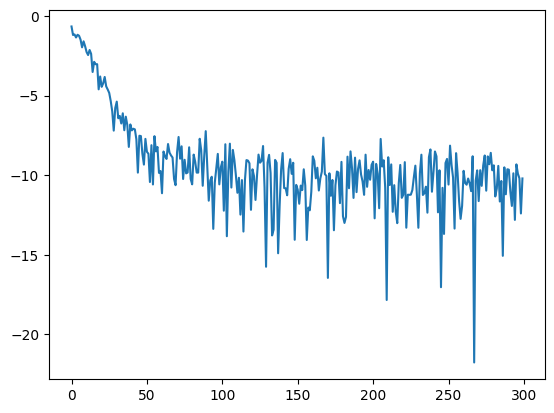

In [1060]:
lossx = train_model(dev_layer, optimizer, train_loader, num_epochs=300)
_, ax = plt.subplots()
plt.plot(range(len(lossx)), lossx)

## Test

In [1061]:
dev_train = dev_layer(tsx_train)
dev_test = dev_layer(tsx_test)

In [1062]:
dev_test.shape

torch.Size([1029, 1, 5, 5])

In [1063]:
dt1 = dev_train[y_train == 1][:, 0, ...]
dt2 = dev_train[y_train == 2][:, 0, ...]

In [1064]:
# ddt1 = dt1 - dt1[torch.randperm(len(dt1))]
# ddt2 = dt2 - dt2[torch.randperm(len(dt2))]
# ddt12 = dt1[:-1] - dt2#[torch.randperm(len(dt1))]
# # norms1 = torch.swapaxes(dt1, 1, 2).bmm(dt1[torch.randperm(len(dt1))]).diagonal(dim1=1, dim2=2).sum(axis=1).detach().numpy()
# norms1 = torch.swapaxes(ddt1, 1, 2).bmm(ddt1).diagonal(dim1=1, dim2=2).sum(axis=1).detach().numpy()
# norms2 = torch.swapaxes(ddt2, 1, 2).bmm(ddt2).diagonal(dim1=1, dim2=2).sum(axis=1).detach().numpy()
# norms12 = torch.swapaxes(ddt12, 1, 2).bmm(ddt12).diagonal(dim1=1, dim2=2).sum(axis=1).detach().numpy()
# # norms2 = torch.swapaxes(dt2, 1, 2).bmm(dt2[torch.randperm(len(dt2))]).diagonal(dim1=1, dim2=2).sum(axis=1).detach().numpy()
# # norms12 = torch.swapaxes(dt1[:-1], 1, 2).bmm(dt2[torch.randperm(len(dt2))]).diagonal(dim1=1, dim2=2).sum(axis=1).detach().numpy()

# _, ax = plt.subplots()
# ax.scatter(norms12, [1.5]*len(norms2))
# ax.scatter(norms1, [1]*len(norms1))
# ax.scatter(norms2, [2]*len(norms2))

In [1082]:
tau1 = torch.mean(dt1, axis=0)
tau2 = torch.mean(dt2, axis=0)

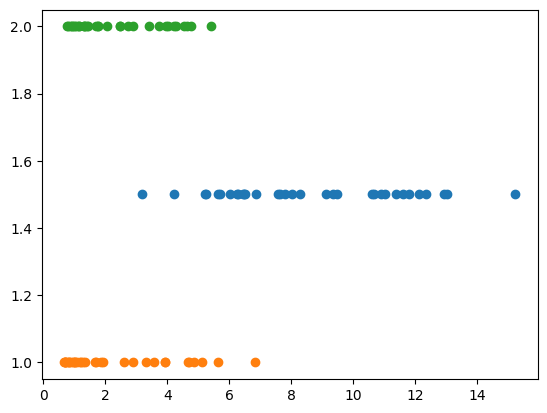

In [1083]:
ddt1 = dt1 - tau1
ddt2 = dt2 - tau2
ddt12 = dt1[:-1] - dt2
# norms1 = torch.swapaxes(dt1, 1, 2).bmm(dt1[torch.randperm(len(dt1))]).diagonal(dim1=1, dim2=2).sum(axis=1).detach().numpy()
norms1 = torch.swapaxes(ddt1, 1, 2).bmm(ddt1).diagonal(dim1=1, dim2=2).sum(axis=1).detach().numpy()
norms2 = torch.swapaxes(ddt2, 1, 2).bmm(ddt2).diagonal(dim1=1, dim2=2).sum(axis=1).detach().numpy()
norms12 = (
    torch.swapaxes(ddt12, 1, 2).bmm(ddt12).diagonal(dim1=1, dim2=2).sum(axis=1).detach().numpy()
)
_, ax = plt.subplots()
ax.scatter(norms12, [1.5] * len(norms2))
ax.scatter(norms1, [1] * len(norms1))
ax.scatter(norms2, [2] * len(norms2))

In [1066]:
# linkage matrix
from scipy.cluster.hierarchy import fclusterdata

In [1097]:
diff1 = (dev_train - tau1)[:, 0, ...]
diff2 = (dev_train - tau2)[:, 0, ...]

dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

c = (dd1 > dd2).detach().numpy().astype(float) + 1

In [1098]:
c

array([1., 1., 2., 2., 1., 2., 2., 1., 1., 2., 2., 1., 1., 2., 1., 2., 1.,
       1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 2., 2., 1., 1., 2., 2., 2.,
       2., 2., 1., 2., 1., 2., 1., 1., 2., 2., 1., 2., 2., 2., 2., 1., 1.,
       2., 2., 2., 1., 2., 2., 1., 1., 2., 2., 1., 1., 2., 1., 2., 2.])

In [1113]:
confusion_matrix(y_train.numpy(), c)

array([[32,  2],
       [ 0, 33]], dtype=int64)

In [1101]:
(y_train == c).sum() / len(y_train)

tensor(0.9701)

In [1105]:
diff1 = (dev_test - tau1)[:, 0, ...]
diff2 = (dev_test - tau2)[:, 0, ...]

dd1 = torch.swapaxes(diff1, 1, 2).bmm(diff1).diagonal(dim1=1, dim2=2).sum(-1)
dd2 = torch.swapaxes(diff2, 1, 2).bmm(diff2).diagonal(dim1=1, dim2=2).sum(-1)

c_test = (dd1 > dd2).detach().numpy().astype(float) + 1
(y_test.numpy() == c_test).sum() / len(y_test)

0.9543245869776482

In [1104]:
confusion_matrix(y_test.numpy(), c_test)

array([[492,  21],
       [ 26, 490]], dtype=int64)

In [1084]:
def hilbert_schmidt_distance(d1, d2):
    d = d1 - d2
    return d.T.matmul(d).diagonal().sum()  # .detach().numpy()

In [1067]:
def hilbert_schmidt_distance_np(d1, d2):
    d1 = Tensor(d1).reshape(hidden_size, hidden_size)
    d2 = Tensor(d2).reshape(hidden_size, hidden_size)
    d = d1 - d2
    return d.T.matmul(d).diagonal().sum()  # .detach().numpy()

In [1068]:
X = dev_train.reshape(len(dev_train), -1).detach().numpy()

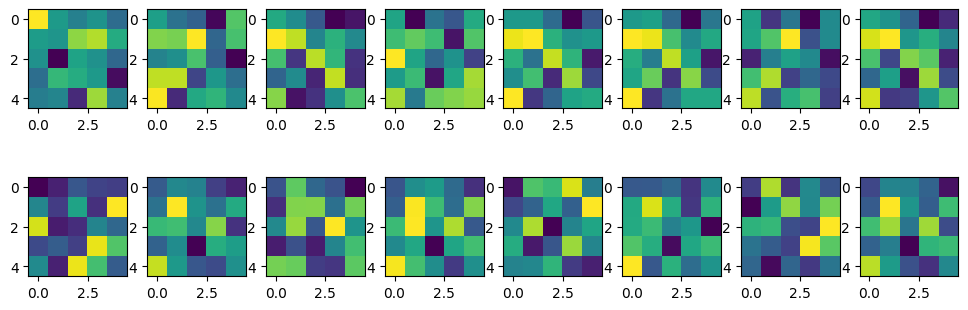

In [1110]:
_, axs = plt.subplots(nrows=2, ncols=8, figsize=(12, 4))
for i in range(8):
    axs[0, i].imshow(dev_train[y_train == 1][i, 0, ...].detach().numpy())
    axs[1, i].imshow(dev_train[y_train == 2][i, 0, ...].detach().numpy())

In [1112]:
torch.save(dev_layer.state_dict(), os.path.join(os.getcwd(), "pdev_ItalyPowerDemand"))

## Compare expected signature

In [1114]:
import signatory

In [ ]:
# hilbert schmidt distance in the truncated tensor algebra